In [1]:
import numpy as np
import pandas as pd
import zarr
import s3fs
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import pint_xarray
from scipy.signal import savgol_filter, medfilt
import json

mpl.rc('font',**{'family':'serif','serif':['Arial Narrow']})

# Latex points to inches conversion factor
PTS_PER_INCH = 72.26999
# Latex text width in points
TEXT_WIDTH_PTS = 505.12177
# Latex column width in points
COLUMN_WIDTH_PTS = TEXT_WIDTH_PTS / 2
# Latex column width in inches
COLUMN_WIDTH_INCHES = COLUMN_WIDTH_PTS / PTS_PER_INCH
# Latex text width in inches
TEXT_WIDTH_INCHES = TEXT_WIDTH_PTS / PTS_PER_INCH
# DPI for figures
DPI = 600
# Font scale for figures
FONT_SCALE = 0.5
# Figure file format
FORMAT = "pdf"

# Seconds to milliseconds conversion factor
SEC_TO_MS = 1000
# Bytes to megabytes conversion factor
BYTES_TO_MB = 1e-6

# Adjust the grid line width
GRID_LINE_WIDTH = 0.1
# Adjust the grid line alpha
GRID_LINE_ALPHA = 0.5

def plot_event(ax, t, color, label=None, alpha: float =1):
    ax.vlines(t, ymin=0, ymax=1, color=color, transform=ax.get_xaxis_transform(), label=label, alpha=alpha)

def plot_region(ax, tmin, tmax, color, label=None):
    ax.axvspan(tmin, tmax, color=color, alpha=0.2, label=label)
    ax.vlines(tmin, ymin=0, ymax=1, color=color, transform=ax.get_xaxis_transform())
    ax.vlines(tmax, ymin=0, ymax=1, color=color, transform=ax.get_xaxis_transform())

def plot_h_mode(ax, h_mode):
    for i, event in enumerate(h_mode):
        tmin, tmax = event['tmin'], event['tmax']
        plot_region(ax, tmin, tmax, color='orange', label=f'H Mode {i}')


### Load Events

Load up the detected events and get file handle

In [2]:
shot_id = 30014
data_dir = Path('example-events')
file_name = (data_dir / f'{shot_id}.json')

with file_name.open('r') as handle:
    events = json.load(handle)

endpoint_url = 'https://s3.echo.stfc.ac.uk'
url = f's3://mast/level2/shots/{shot_id}.zarr'

fs = s3fs.S3FileSystem(
  anon=True, endpoint_url=endpoint_url
)
store = zarr.storage.FSStore(fs=fs, url=url)

## Flat-Top, Ramp-Up & Disruption

<xarray.DataArray 'ip' (time: 3573)> Size: 29kB
[3573 values with dtype=float64]
Coordinates:
  * time     (time) float64 29kB -0.1044 -0.1042 -0.104 ... 0.6096 0.6098 0.61
Attributes:
    description:  
    imas:         magnetics.ip[:].data
    label:        Plasma Current
    name:         ip
    uda_name:     AMC_PLASMA CURRENT
    units:        A

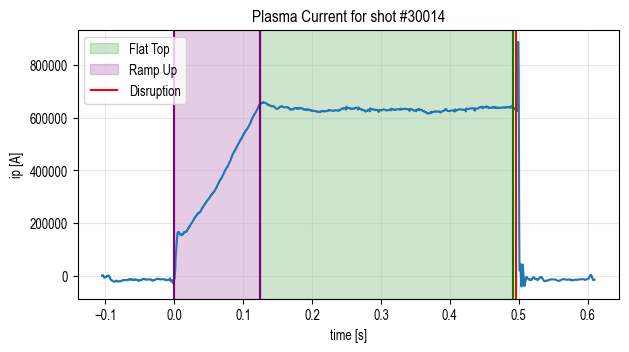

In [3]:

magnetics = xr.open_zarr(store, group="magnetics")
ip = magnetics['ip']

fig, ax = plt.subplots(1,1, figsize=(TEXT_WIDTH_INCHES, COLUMN_WIDTH_INCHES))
ip.plot(ax=ax)

ymin, ymax = ax.get_ylim()

# Flat top
flat_top_min = events['general']['flat_top']['tmin']
flat_top_max = events['general']['flat_top']['tmax']
plot_region(ax, flat_top_min, flat_top_max, color='green', label='Flat Top')


# Ramp up
ramp_up_min = events['general']['ramp_up']['tmin']
ramp_up_max = events['general']['ramp_up']['tmax']
plot_region(ax, ramp_up_min, ramp_up_max, color='purple', label='Ramp Up')

disruption = events['general']['disruption']['td']
current = events['general']['disruption']['current']
plot_event(ax, disruption, color='red', label='Disruption')


ax.grid('both', alpha=0.3)
ax.legend(loc='upper left')
ax.set_title(f'Plasma Current for shot #{shot_id}')
ip

## Confinement Mode

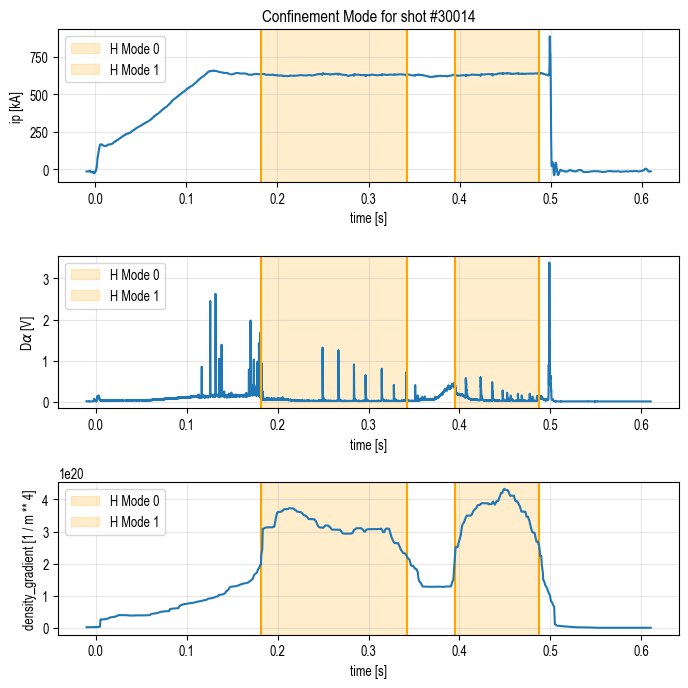

In [4]:

magnetics = xr.open_zarr(store, group="magnetics")
ip = magnetics['ip']
ip = ip.pint.quantify()
ip = ip.pint.to('kA')
ip = ip.pint.dequantify(format="~P")

spec = xr.open_zarr(store, group="spectrometer_visible")
dalpha = spec.filter_spectrometer_dalpha_voltage
dalpha = dalpha.isel(dalpha_channel=2)
dalpha = dalpha.dropna(dim='time')
dalpha.name = 'D$\\alpha$'

density = spec.density_gradient.dropna(dim='time')
density.loc[density.time > 0.55] = 0
density.values = savgol_filter(density.values, 100, 2)
density.values = medfilt(density.values, kernel_size=3001)
density = density

ip = ip.sel(time=slice(dalpha.time.min(), dalpha.time.max()))
density = density.sel(time=slice(dalpha.time.min(), dalpha.time.max()))

fig, axes = plt.subplots(3, 1, figsize=(TEXT_WIDTH_INCHES, COLUMN_WIDTH_INCHES*2))

ip.plot(ax=axes[0])

dalpha.plot(ax=axes[1])

plot_h_mode(axes[0], events['h_mode']['events'])
plot_h_mode(axes[1], events['h_mode']['events'])
plot_h_mode(axes[2], events['h_mode']['events'])

for ax in axes:
    ax.grid('both', alpha=0.3)
    ax.legend(loc='upper left')

density.plot(ax=axes[2])

axes[0].set_title(f'Confinement Mode for shot #{shot_id}')
axes[1].set_title('')
plt.tight_layout()

## Locked Mode

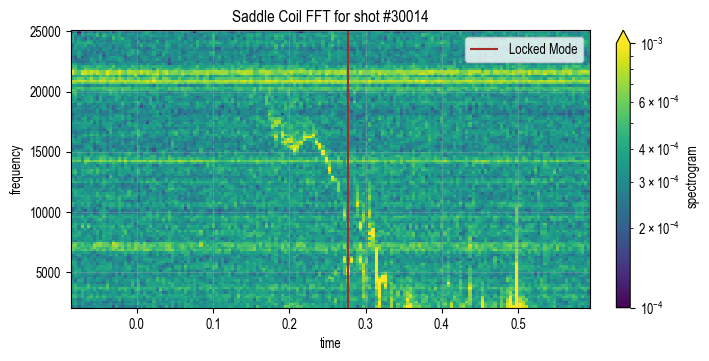

In [5]:
from scipy.signal import stft

def get_saddle_coil_channel_fft(data, nperseg=128):
    ds = data
    # Compute the Short-Time Fourier Transform (STFT)
    sample_rate = 1 / (ds.time[1] - ds.time[0])
    f, t, Zxx = stft(ds, fs=int(sample_rate), nperseg=nperseg, noverlap=nperseg // 5)

    t = t + ds.time.values[0]
    spec = xr.DataArray(np.abs(Zxx), coords=dict(frequency=f, time=t))
    angles = xr.DataArray(np.angle(Zxx, deg=True), coords=dict(frequency=f, time=t))
    dataset = xr.Dataset(dict(spectrogram=spec, phases=angles))

    return dataset

magnetics = xr.open_zarr(store, group="magnetics")
saddle_coils = magnetics["b_field_tor_probe_saddle_voltage"]
saddle_coils = saddle_coils.rename(
    dict(time_saddle="time", b_field_tor_probe_saddle_voltage_channel="channel")
)

specs = []
for i in range(len(saddle_coils.channel)):
    saddle_coil = saddle_coils.isel(channel=i)
    spec = get_saddle_coil_channel_fft(saddle_coil, nperseg=256)
    specs.append(spec.spectrogram)

coil_fft = sum([coil_fft for coil_fft in specs])
coil_fft = coil_fft.sel(frequency=coil_fft.frequency > 2000)
coil_fft = coil_fft.sel(
    time=slice(coil_fft.time.min() + 0.02, coil_fft.time.max() - 0.02)
)


fig, ax = plt.subplots(1, 1, figsize=(TEXT_WIDTH_INCHES, COLUMN_WIDTH_INCHES),  sharex=True, layout='constrained')
coil_fft = coil_fft.sel(frequency=coil_fft.frequency > 2)
coil_fft.plot(ax=ax, norm=mpl.colors.LogNorm(vmin=1e-4, vmax=1e-3))

if 'locked_mode' in events:
    plot_event(ax, events['locked_mode']['time'], color='brown', label='Locked Mode')

ax.set_title(f'Saddle Coil FFT for shot #{shot_id}')
ax.legend()
ax.grid('both', alpha=0.3)

## Sawteeth

/var/folders/xr/yr8z575s52b4tbg3fj65qwx00000gp/T/ipykernel_65938/3711712067.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


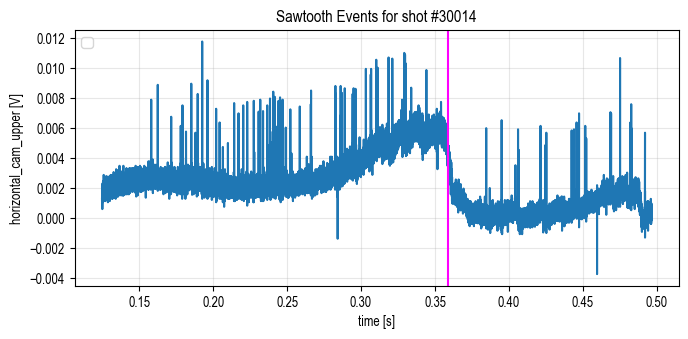

In [6]:
magnetics = xr.open_zarr(store, group="magnetics")
ip = magnetics['ip']
ip = ip.sel(time=slice(flat_top_min, flat_top_max))

ds = xr.open_zarr(store, group='soft_x_rays')
hcam = ds['horizontal_cam_upper']
channel = hcam.isel(horizontal_cam_upper_channel=5)
channel = channel.dropna(dim='time')
channel = channel.sel(time=slice(flat_top_min, disruption))

fig, ax = plt.subplots(1, 1, figsize=(TEXT_WIDTH_INCHES, COLUMN_WIDTH_INCHES))

channel.plot(ax=ax)
ax.set_title('')
for event in events['sawteeth']['events']:
    time = event['time']
    plot_event(ax, time, color='magenta')

ax.grid('both', alpha=0.3)
ax.legend(loc='upper left')
ax.set_title(f'Sawtooth Events for shot #{shot_id}')

plt.tight_layout()

## ELMs

Text(0.5, 1.0, 'ELM Events for shot #30014')

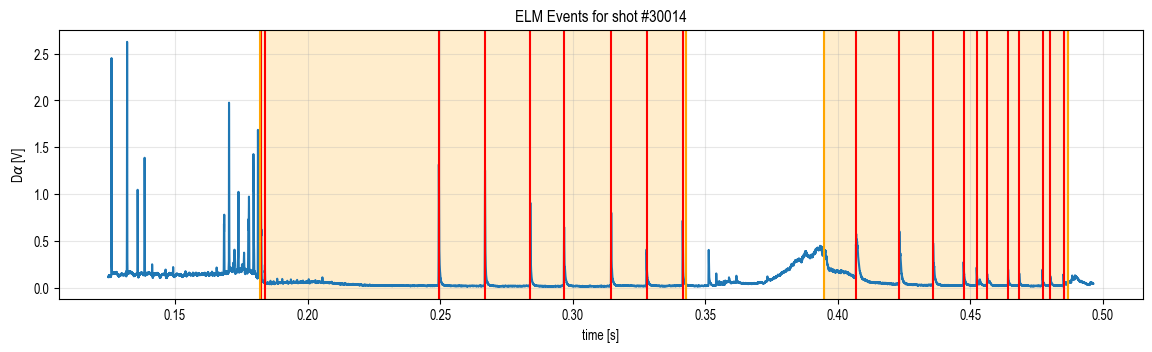

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(TEXT_WIDTH_INCHES*2, COLUMN_WIDTH_INCHES))
dalpha.sel(time=slice(flat_top_min, disruption)).plot(ax=ax)

h_mode = events['h_mode']['events']
for event in events['elms']['events']:
    time = event['time']

    valid = False
    for mode_region in h_mode:
        if time > mode_region['tmin'] and time < mode_region['tmax']:
            valid = True

    # valid = event['valid'] and valid
    if valid:
        plot_event(ax, time, color='red')

plot_h_mode(ax, h_mode)
ax.grid('both', alpha=0.3)
ax.set_title(f'ELM Events for shot #{shot_id}')